<a href="https://colab.research.google.com/github/Feynman520/Cosmos/blob/main/Stock_Forecast_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File Upload

In [ ]:
from google.colab import files
upload = files.upload()

Saving samsung test.csv to samsung test.csv


# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime



*   pandas : 데이터 분석을 위한 라이브러리
*   numpy : 행렬 연산을 위한 라이브러리
*   matplotlib : 예측 결과를 시각화하기 위한 라이브러리
*   keras : 딥러닝 모델을 간편하게 사용하기 위한 프레임워크
*   datetime : 년월일 시간을 다루기 위한 라이브러리



# Laod Dataset

In [ ]:
data = pd.read_csv('samsung test.csv')
display(data.head())
data_index = data.index
print("데이터 전체 행의 수 : ",len(data_index))
print((data["High"][1224]+data["High"][1224])/2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-09,38780.0,38840.0,38220.0,38400.0,33323.406250,13694150
1,2017-02-10,38400.0,38760.0,38300.0,38360.0,33288.691406,11020750
2,2017-02-13,37740.0,38060.0,37720.0,37960.0,32941.578125,11102050
3,2017-02-14,37960.0,38260.0,37320.0,37580.0,32611.806641,13124150
4,2017-02-15,37080.0,37960.0,37080.0,37720.0,32733.304688,14191550


데이터 전체 행의 수 :  1225
74700.0




*   data : 학습, 예측에 사용할 시계열 데이터.
*   저장된 시계열 데이터의 앞부분 1~5번째 데이터를 출력해 확인합니다.
*   data_index : 데이터의 인덱스 행.
*   저장된 data_index의 길이 즉, 데이터의 수를 확인합니다.

▶ 삼성전자의 5년치 데이터는 날짜(Data), 시작가(Open), 최고가(Hige), 최저가(Low), 마감가(Close), 수정 종가(Adj Close), 거래 총량(Volume)라는 Feature들로 구성되어 있습니다.
▶ 삼성전자의 5년치 데이터는 총 1225개입니다.

# Compute Mid Price

In [ ]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2



*   high_prices : 삼성전자 데이터의 3열인 최고가(High)에 해당하는 5년치 데이터의 값.
*   Low_prices : 삼성전자 데이터의 4열인 최저가(Low)에 해당하는 5년치 데이터의 값.
*   mid_prices : 우리가 학습하고 예측에 사용할 하루의 최고값과 최저값의 평균인 중간값.



# Create Windows

In [ ]:
seq_len = 50
sequence_length = seq_len + 1

window_list = []
for index in range(len(mid_prices) - sequence_length):
    window_list.append(mid_prices[index: index + sequence_length])
print("첫번째 window : ",window_list[0])
print("첫번째 window의 길이 : ",len(window_list[0]))
print("window의 총개수 : ",len(window_list))

첫번째 window :  [38530. 38530. 37890. 37790. 37520. 38070. 37660. 38470. 38990. 39160.
 39230. 38580. 37920. 38360. 39140. 39440. 39720. 40060. 40380. 40160.
 40140. 40510. 41020. 41120. 41860. 42110. 41930. 42220. 42020. 42030.
 41530. 41530. 41610. 41770. 42160. 41610. 41510. 41850. 41970. 41840.
 41490. 41720. 41760. 41820. 42060. 42010. 41800. 41550. 41160. 40440.
 40940.]
첫번째 window의 길이 :  51
window의 총개수 :  1174




▶학습, 예측할 데이터 단위는 window 입니다.
*   seq_len : 설정할 window의 학습 근거 데이터수.
*   sequence_length : seq_len + seq_len를 근거로 예측할 데이터수.(window size)
*   window_list : size가 51인 window들의 집합 리스트.<br/>
&#35; 한칸씩 밀리면서 생성한 window를 저장할 빈 리스트 를 생성합니다.(여기에서 window는 numpy array입니다.)
*   한칸씩 밀리면서 생성하기 위해 전체 행의수 1225개에서 51개를 뺀 수부터 반복을 시작합니다.(index = 0 ~ 1173)
*   mid_prices에서 index ~ index+51 범위 값이 window이므로 window_list에 저장합니다.
*   window_list의 첫번째 window는 2017-02-09 ~ 2017-04-21의 51개 데이터가 저장됩니다.
*   windw의 총개수는 1174개이고, 한개의 window에 들어있는 데이터 개수는 51개 입니다.<br/>
&#35; window : 51개의 데이터를 담고 있는 창문.<br/>
&#35; window_data : window 속 데이터 1개.<br/>
&#35; window_list : 1174개의 window를 모아놓은 리스트.


# Normalize Data

In [ ]:
normalized_window_list = []
for window in window_list:
    normalized_window = [((float(window_data) / float(window[0])) - 1) for window_data in window]
    normalized_window_list.append(normalized_window)

result = np.array(normalized_window_list)



▶각 window의 첫번째 데이터를 0으로 잡고, 그 비율을 계산하여 정규화시킵니다.
*   normalized_window_list : 정규화된 winddow의 집합 리스트.
*   1174개의 window를 차례대로 반복 대입합니다.
*   대입한 window는 51개의 데이터를 가지고 있고, 하나씩 꺼내어 window_data에 대입합니다.
*   window_data는 1개의 데이터이며 각 window의 첫번째 window_data를 0으로 잡고, 비율을 계산합니다.

# Split Train and Test Data

In [ ]:
print("result의 shape : ",result.shape)
row = int(round(result.shape[0] * 0.9))
print("훈련데이터수 : ",row)
train = result[:row, :]
print("train의 shape : ",train.shape)
np.random.shuffle(train)

x_train = train[:, :-1]
print("x_train의 shape : ",x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
print("y_train의 shape : ",y_train.shape)

x_test = result[row:, :-1]
print("x_test의 shape : ",x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]
print("y_test의 shape : ",y_test.shape)

x_train.shape, x_test.shape

result의 shape :  (1174, 51)
훈련데이터수 :  1057
train의 shape :  (1057, 51)
x_train의 shape :  (1057, 50)
y_train의 shape :  (1057,)
x_test의 shape :  (117, 50)
2
y_test의 shape :  (117,)


((1057, 50, 1), (117, 50, 1))


▶51개 데이터를 담은 1174개의 window 집합 2차 array인 result를 분리합니다.
*   row : 정규화된 window들의 90%의 수.<br/>
&#35; 정규화된 window 세트는 result에 저장되어 있으며 result.shape는 (행, 열)이고, 0번째 인덱스는 result에 들어있는 window 세트의 수를 의미합니다.
*   train : result에서 0~row(1057)행에 해당하는 데이터.<br/>
&#35; result[0] = 2017-02-09에서 2017-03 까지의 데이터이고, result[1057] = 2021-06-04부터 2021-08-17까지의 데이터 이므로 2021.08.17 이전 데이터를 학습하고 이후 데이터를 예측하게 됩니다.
*   train 데이터를 무작위로 섞습니다.
*   x_train : window의 90%에 해당하는 데이터 51개 중 제일 마지막 데이터를 제외한 데이터 50개.(input 데이터)
*   LSTM 모델의 입력 노드는 50, 출력 노드는 1이므로 (50,1)로 reshape을 합니다.
*   y_train : window의 90%에 해당하는 데이터 51개 중 제일 마지막 데이터 1개.(output 데이터)<br/>
&#35; 이미지를 다룰때의 이미지(input), 정답(output)과 다름에 유의해야 합니다.
*   x_test : window의 10%에 해당하는 데이터 51개 중 제일 마지막 데이터를 제외한 데이터 50개.(input 데이터)
*   LSTM 모델의 입력 노드는 50, 출력 노드는 1이므로 (50,1)로 reshape을 합니다.
*   y_test : window의 10%에 해당하는 데이터 51개 중 제일 마지막 데이터 1개.(output 데이터)


# Build a Model

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________




*   model : keras의 seqential() 인스턴스.<br/>
&#35; model은 텅빈 인스턴스로 add를 통해서 layer를 쌓아야 합니다.
*   LSTM layer를 생성하고 sequntial에 추가합니다.
&#35; 입력되는 데이터의 shape는 (50,1)입니다.
*   출력 layer는 dense 함수를 이용하여 출력 노드 1개, 활성화 함수는 linear로 생성하여 추가합니다.
*   compile 함수를 이용하여 손실함수는 mse, 옵티마이저는 rmsprop을 설정하고 생성하여 추가합니다.
*   완성된 모델 인스턴스를 요약해서 출력합니다.


# Training

In [ ]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 11s 60ms/step - loss: 0.0022 - val_loss: 7.3567e-04
Epoch 2/20
106/106 [==============================] - 5s 50ms/step - loss: 9.6230e-04 - val_loss: 5.5501e-04
Epoch 3/20
106/106 [==============================] - 5s 47ms/step - loss: 7.0997e-04 - val_loss: 3.6038e-04
Epoch 4/20
106/106 [==============================] - 5s 47ms/step - loss: 5.9704e-04 - val_loss: 2.2571e-04
Epoch 5/20
106/106 [==============================] - 5s 47ms/step - loss: 4.8066e-04 - val_loss: 2.0764e-04
Epoch 6/20
106/106 [==============================] - 5s 47ms/step - loss: 4.1808e-04 - val_loss: 1.6912e-04
Epoch 7/20
106/106 [==============================] - 5s 48ms/step - loss: 3.2923e-04 - val_loss: 4.1514e-04
Epoch 8/20
106/106 [==============================] - 5s 48ms/step - loss: 3.1588e-04 - val_loss: 2.0942e-04
Epoch 9/20
106/106 [==============================] - 5s 48ms/step - loss: 3.3407e-04 - val_loss: 1.2696e-04
Epoch 10/20
106/106 [=



*   완성된 모델을 fit함수를 이용하여 학습시킵니다.<br/>
&#35; 준비했던 학습, 평가 데이터를 설정하고, batch의 크기는 10개로 에폭은 20으로 설정합니다.



# Prediction

In [ ]:
pred = model.predict(x_test)
pred_table = []
for i in pred:
  pred_table.append((i+1)*float(window[0]))

date = pd.date_range(start="20210831", end="20220209",freq='B')
date_table = list(date)

a = {'Date': date_table, 'Prices': pred_table}
b = pd.DataFrame(a)

display(b)

,Date,Prices
0,2021-08-31,[71431.15]
1,2021-09-01,[69084.68]
2,2021-09-02,[69146.08]
3,2021-09-03,[68987.375]
4,2021-09-06,[69319.74]
...,...,...
112,2022-02-03,[77005.016]
113,2022-02-04,[77613.16]
114,2022-02-07,[79476.65]
115,2022-02-08,[75473.18]




*   pred : 학습된 모델이 x_test에 대한 예측값을 모아놓은 array.
*   정규화된 모델 예측값을 다시 역연산하고, pred_table에 추가합니다.
*   date : 판다스의 date_range함수를 사용하여 2021-08-31부터 2022-02-09 범위의 주중 날짜.
*   date의 자료형을 리스트로 변환하고, date_table과 pred_table을 이용하여 DataFrame을 생성합니다.



# Data Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


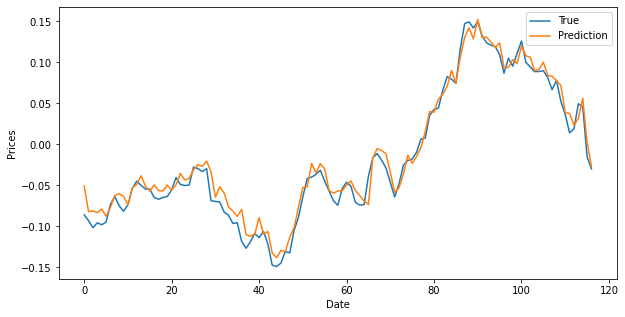

In [ ]:
fig = plt.figure(facecolor='white', figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Prices")
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# Price Forecast for Tomorrow

In [ ]:
to_data = result[1173, 1:]
to_x_data = np.reshape(to_data, (1,to_data.shape[0], 1))

to_pred = model.predict(to_x_data)
to_pred_table = []
for i in to_pred:
  to_pred_table.append((i+1)*float(window[0]))

a = {'Date': ["2022-02-10"], 'Prices': to_pred_table}
b = pd.DataFrame(a)

display(b)

,Date,Prices
0,2022-02-10,[73488.13]


# Price Forecast for Week

In [ ]:
new_data = np.concatenate(np.reshape(1,to_data[1:]),to_pred)

